<a href="https://colab.research.google.com/github/jsmazorra/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/Johan_Mazorra__LS_DS13_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [15]:
train.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year_recorded,month_recorded,day_recorded,years
count,58806.000000,58806.00000,57010.000000,57010.000000,58806.000000,58806.000000,58806.000000,58806.000000,58806.000000,58806.000000,58806.000000,58806.000000,58806.000000
mean,316.736674,668.58744,35.150319,-5.884363,0.470836,15.289426,5.629970,179.723226,1300.784206,2011.921437,4.375880,15.620209,711.137231
std,2972.924432,693.21649,2.606935,2.809032,12.229290,17.580722,9.638494,471.812010,951.577710,0.958975,3.028969,8.689964,951.237955
min,0.000000,-90.00000,29.607122,-11.649440,0.000000,1.000000,0.000000,0.000000,0.000000,2002.000000,1.000000,1.000000,-7.000000
25%,0.000000,0.00000,33.285463,-8.643062,0.000000,5.000000,2.000000,0.000000,0.000000,2011.000000,2.000000,8.000000,8.000000
50%,0.000000,370.00000,35.007392,-5.171612,0.000000,12.000000,3.000000,25.000000,1986.000000,2012.000000,3.000000,16.000000,26.000000
75%,20.000000,1320.00000,37.234737,-3.372798,0.000000,17.000000,5.000000,214.000000,2004.000000,2013.000000,7.000000,23.000000,2011.000000
max,350000.000000,2770.00000,40.345193,-0.998464,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2013.000000,12.000000,31.000000,2013.000000


In [16]:
test.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,14358.000000,14358.000000,14358.0000,14358.000000,1.435800e+04,14358.000000,14358.000000,14358.000000,14358.000000,14358.000000
mean,37232.859799,324.219996,653.6363,34.082414,-5.697584e+00,0.408971,15.156359,5.713052,187.055439,1298.251985
std,21382.890432,2533.367778,688.2721,6.564449,2.947444e+00,8.231859,17.387588,9.794304,476.065978,952.551852
min,10.000000,0.000000,-57.0000,0.000000,-1.156459e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18765.500000,0.000000,0.0000,33.062317,-8.453125e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37442.000000,0.000000,346.0000,34.898976,-5.087905e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55909.250000,25.000000,1306.0000,37.221606,-3.314240e+00,0.000000,17.000000,5.000000,230.000000,2004.000000
max,74249.000000,200000.000000,2777.0000,40.325016,-2.000000e-08,669.000000,99.000000,80.000000,11469.000000,2013.000000


In [17]:
train.describe(include='object')

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,55203,55184,58806,58806,58441,58806,58806,58806,55514,54974,30919,55781,58806,58806,58806,58806,58806,58806,58806,58806,58806,58806,58806,58806,58806,58806,58806
unique,1888,2135,37070,9,19200,21,125,2092,2,12,2690,2,18,13,7,12,5,7,8,6,5,10,7,3,7,6,3
top,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,9004,17221,3532,10141,505,5245,2481,302,50513,36414,676,38466,26527,26527,26527,40099,51967,25086,50310,50310,32860,16864,16864,45343,28246,34276,31936


In [18]:
test.describe(include='object')

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,14358,13575,13570,14358,14358,14264,14358,14358,14358,13573,14358,13419,7519,13695,14358,14358,14358,14358,14358,14358,14358,14358,14358,14358,14358,14358,14358,14358,14358,14358
unique,331,960,1075,10615,9,8253,21,124,1934,2,1,11,1772,2,17,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,2011-03-16,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Shinyanga,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,Borehole,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,communal standpipe,communal standpipe
freq,137,2117,4162,822,2535,136,1258,611,79,12308,14358,8807,158,9442,6168,6168,6168,9780,12639,6098,6098,12237,12237,7997,7997,4211,4211,11127,6790,8260


In [0]:
# This is going to be the same code as yesterday.
import numpy as np
from sklearn.model_selection import train_test_split

# Let's start by splitting the training data into both train and val.
train, val = train_test_split(train, train_size=.99, test_size=.01, stratify=train['status_group'], random_state=42)

def fix_data(X):
  X = X.copy()

  # This is to clean up the zeros.
  X['latitude'] = X['latitude'].replace(-2e-08,0)
  X['longitude'] = X['longitude'].replace(-2e-08,0)
  cols = ['longitude','latitude']
  for col in cols:
    X[col] = X[col].replace(0, np.nan)
    X[col+'_MISSING']= X[col].isnull()
  
  # Let's drop the columns that are duplicated.
  duplicates = ['quantity_group','payment_type']
  X = X.drop(columns=duplicates)

  X = X.drop(columns=['recorded_by','id'])

  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()

  return X

train = fix_data(train)
val = fix_data(val)
test = fix_data(test)

In [0]:
# Next, let's set up the target and features.
target = 'status_group'

features = train.drop(columns=[target])

# Let's get the numerical features.
num_feats = features.select_dtypes(include='number').replace(-2e-08,0)
num_feats = features.select_dtypes(include='number').columns.tolist()

# And then the low cardinal categorical ones.
cat_feats = features.select_dtypes(exclude='number').nunique()
cat_feats = cat_feats[cat_feats <= 50].index.tolist()

features = num_feats + cat_feats

In [0]:
# Make the respective matrices.
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [8]:
# Import the necessary libraries.
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(bootstrap=True, max_depth=70, max_features='auto', min_samples_leaf= 1, min_samples_split= 5, n_estimators=900, random_state=42, criterion='entropy')
)

pipeline.fit(X_train, y_train)
print('Training Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Training Accuracy: 0.9581335237900894
Validation Accuracy: 0.8198653198653199


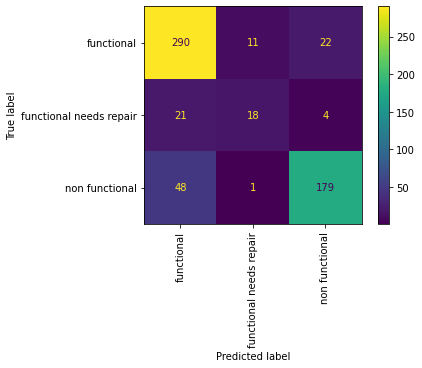

In [10]:
# Let's fit the pipeline from the one that gave us the best results.
pipeline.fit(X_train, y_train)

# Create a confusion matrix.
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f',xticks_rotation='vertical')

y_pred_proba = pipeline.predict_proba(X_val)[:,1]

In [11]:
# Let's set up a confusion matrix that is interactive.
from sklearn.metrics import classification_report
import seaborn as sns
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
def show_confusion_matrix_graph(y_true, y_pred_proba, good_thresh=0.5, ok_thresh=0.25):
  y_pred = []
  for val in y_pred_proba:
    if val > good_thresh:
      y_pred.append('functional')
    elif val < good_thresh and val > ok_thresh:
      y_pred.append('functional needs repair')
    else:
      y_pred.append('non functional')
  ax = sns.distplot(y_pred_proba)
  ax.axvline(good_thresh, color='green')
  ax.axvline(ok_thresh, color='red')
  plt.show()
  print(classification_report(y_val, y_pred))

interact(show_confusion_matrix_graph, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba),
         good_thresh=(0, 1, .02),
         ok_thresh=(0, 1, .02))

interactive(children=(FloatSlider(value=0.5, description='good_thresh', max=1.0, step=0.02), FloatSlider(value…

<function __main__.show_confusion_matrix_graph>

In [13]:
# Not the predictions that I wanted, definitely won't be using them.
y_pred = pipeline.predict(X_test)

test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
kaggle_sub = test.copy()
kaggle_sub = pd.DataFrame(data=y_pred,index=test['id'],columns=['status_group'])

kaggle_sub.head()

,status_group
id,
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional


In [0]:
sample_submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional


In [0]:
kaggle_sub.to_csv('Lambda_Kaggle_Challenge_Johan_Mazorra_.csv')